# Dettagli ISS

Sesso, età, stato clinico.

> Max Pierini

***

Fonte dati: [EpiCentro-ISS](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import display, Markdown

In [2]:
url = "https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx"

# PERCENTUALE SINTOMATICI

In [3]:
sint = pd.read_excel(
    url,
    sheet_name='casi_inizio_sintomi_sint',
)

sint.index = pd.to_datetime(sint.DATA_INIZIO_SINTOMI, format='%d/%m/%Y')

sint.index.name = 'date'

In [4]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end, ignore_under=50):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        if incid_sum > ignore_under and t_end[t] > final_mean_si:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + np.sum(_lambda[t_start[t]:t_end[t]+1]))
        else:
            a_posterior[t] = 0.1
            b_posterior[t] = 1.0
    return a_posterior, b_posterior

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 ignore_under=50,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - .99) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    #SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_x = np.arange(0, incid.size, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_tot = SI_y / SI_y.sum()
    #SI_tot = SI_y[1:]
    # pad SI with zeros
    #SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2    # shape
    b_prior = (sd_prior ** 2) / mu_prior    # scale
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end,
        ignore_under=ignore_under)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    #offset_idx = int(np.floor(window/2))
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:
        fig, ax = plt.subplots(figsize=(12, 5))
        _ = res.plot(y='R', ax=ax, color='k')
        ax.fill_between(
            res_index,
            quantile_lo_posterior, quantile_hi_posterior,
            color='k', alpha=.2,
            label=f'CI {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ylim = ax.get_ylim()
        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method), window {window} days',
                  #f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days',
            ylim=(0, min(12, ylim[1])),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='lower left')
        plt.show()
    
    return res

In [5]:
ISS_sh = 1.87
ISS_ra = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def generation_time_gamma(sh, ra, plot=True, title='Estimated', size=None):

    dist = sps.gamma(a=sh, scale=1/ra)

    if size == None:
        max_x = int(np.ceil(dist.ppf(.9999)))
    else:
        max_x = size
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

In [6]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)
cov.index = cov.index.normalize()

Per stimare la percentuale di nuovi casi sintomatici sul totale dei nuovi casi, è prima necessario aggiustare il ritardo tra inizio sintomi (come definito da ISS) e comunicazione dei casi da parte di DPC.

Si nota un ritardo di circa 10 giorni.

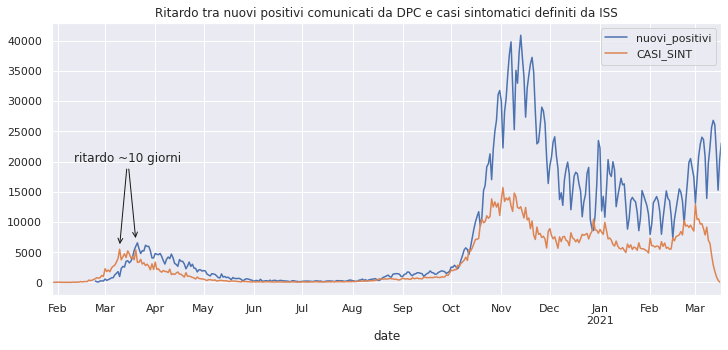

In [7]:
ax = cov[['nuovi_positivi']].plot(
    figsize=(12, 5),
    title='Ritardo tra nuovi positivi comunicati da DPC e casi sintomatici definiti da ISS'
)
sint.dropna()[['CASI_SINT']].plot(ax=ax)
ax.annotate(
    'ritardo ~10 giorni',
    xy=('2020-03-10', 6000),
    xytext=('2020-03-15', 20000),
    arrowprops=dict(color='k', arrowstyle='->'),
    ha='center'
)
ax.annotate(
    'ritardo ~10 giorni',
    xy=('2020-03-20', 7000),
    xytext=('2020-03-15', 20000),
    arrowprops=dict(color='k', arrowstyle='->'),
    ha='center',
    alpha=0
)
plt.show()

In [8]:
window = 7
#cov_roll = cov[['nuovi_positivi']].rolling(window=window).mean()
#cov_roll.index = cov_roll.index - pd.Timedelta(days=window/2)
sin_roll = sint.dropna()[['CASI_SINT']].rolling(window=window).mean()
sin_roll.index = sin_roll.index - pd.Timedelta(days=window/2)

cov['data_adj'] = cov.index - pd.Timedelta(days=10)

cov_adj = cov[['data_adj', 'nuovi_positivi']].set_index('data_adj')

Aggiustando il ritardo possiamo pertanto far combaciare i massimi locali delle due curve.

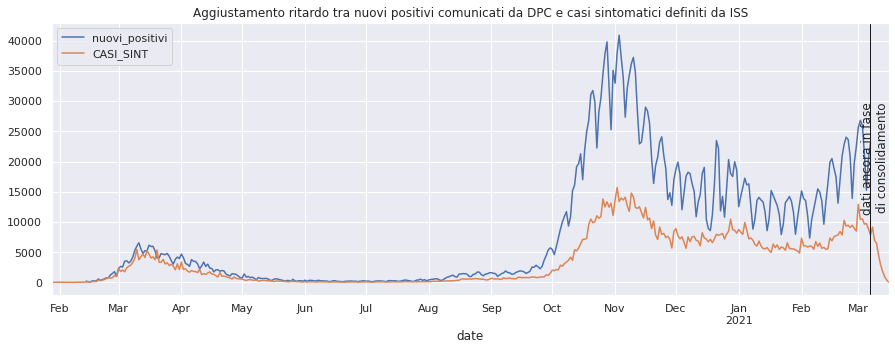

In [9]:
ax = cov_adj.plot(
    y='nuovi_positivi', figsize=(15, 5),
    title='Aggiustamento ritardo tra nuovi positivi comunicati da DPC e casi sintomatici definiti da ISS'
)
sint.dropna()[['CASI_SINT']].plot(ax=ax)
ax.axvline(cov_adj.index[-1], color='k', lw=1)
ax.text(
    sint.index[-2], np.mean(ax.get_ylim()),
    'dati ancora in fase\ndi consolidamento',
    ha='right', va='center', rotation=90
)
plt.show()

Prima di calcolare la percentuale di sintomatici, smussiamo con media mobile (finestra 7 giorni) per ridurre gli effetti dei bias nei report (stagionalità settimanale).

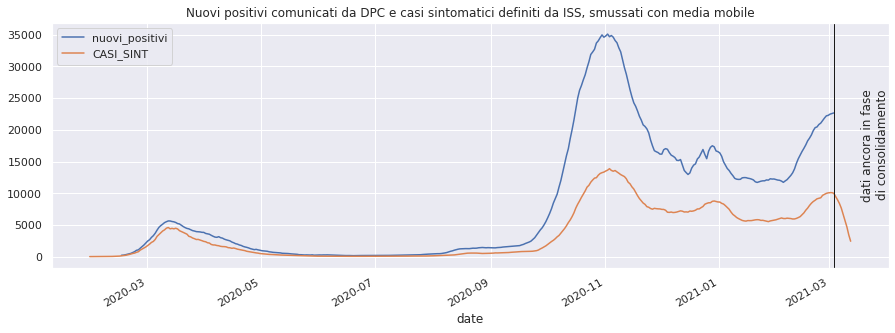

In [10]:
cov_adj_roll = cov_adj[['nuovi_positivi']].rolling(window=window).mean()
cov_adj_roll.index = cov_adj_roll.index - pd.Timedelta(days=window/2)

ax = cov_adj_roll.plot(
    figsize=(15, 5),
    title='Nuovi positivi comunicati da DPC e casi sintomatici definiti da ISS, smussati con media mobile'
)
sin_roll.plot(ax=ax)
ax.axvline(cov_adj_roll.index[-1], color='k', lw=1)
ax.text(
    ax.get_xlim()[-1], np.mean(ax.get_ylim()),
    'dati ancora in fase\ndi consolidamento',
    ha='right', va='center', rotation=90
)
plt.show()

In [11]:
cov_sint = cov_adj_roll.merge(
    sin_roll,
    left_index=True, right_index=True
)

cov_sint['pct_sintomatici'] =  cov_sint.CASI_SINT / cov_sint.nuovi_positivi

Cacoliamo infine la percentuale di sintomatici.

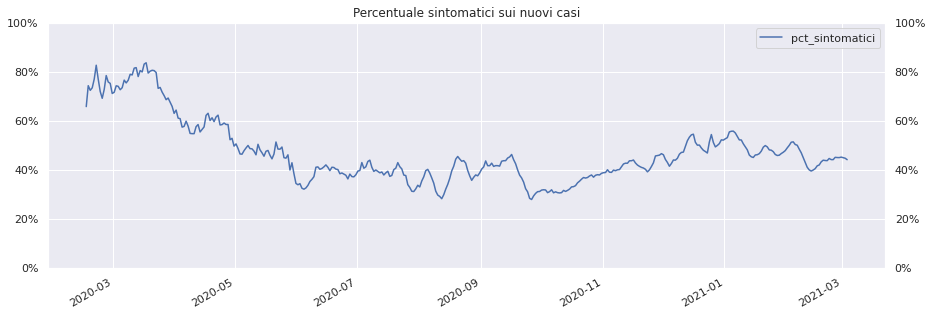

In [12]:
ax = cov_sint.plot(
    y='pct_sintomatici', figsize=(15, 5),
    ylim=(0,1),
    title='Percentuale sintomatici sui nuovi casi'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.show()

Mostriamo di seguito anche il numero di riproduzione $R_t$ stimato sui soli casi sintomatici, con metodo EpiEstim su finestra temporale di 14 giorni, escludendo dalla stima le ultime 2 settimane (in fase di aggiornamento e consolidamento) e imputando il valore stimato di $R_t$ all'ultimo giorno di ciascuna finestra.

La stima è sovrapponibile alle stime di EpiData sui casi totali (vedi [Stime Rt](https://www.epidata.it/Italia/Rt_stime.html)).

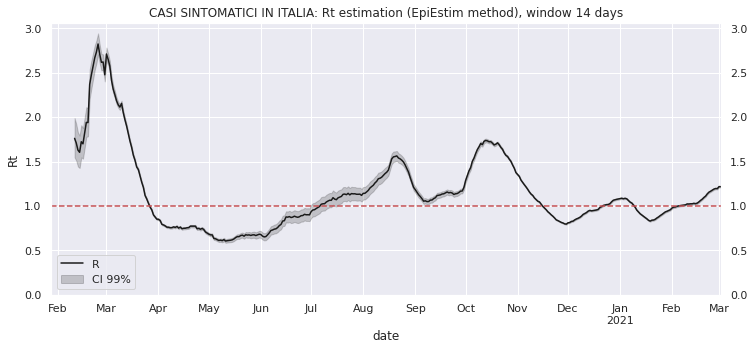

In [13]:
Rt = epi_estim_Rt(
    sint.dropna().iloc[:-14].CASI_SINT, 
    SI_sh=ISS_sh, 
    SI_ra=ISS_ra, 
    window=14, 
    plot_Rt=True,
    title='CASI SINTOMATICI IN ITALIA'
)

# DECESSI

In [14]:
sesso_eta = pd.read_excel(
    url,
    sheet_name='sesso_eta',
    #parse_dates=['iss_date']
)

In [15]:
sesso_eta['iss_date'] = pd.to_datetime(sesso_eta.iss_date, format='%d/%m/%Y')

In [16]:
sesso_eta.replace('<5', 5, inplace=True)

In [17]:
sesso_eta['DECEDUTI'] = sesso_eta.DECEDUTI.astype(int)

In [18]:
sesso_eta['CASI_CUMULATIVI'] = sesso_eta.CASI_CUMULATIVI.astype(int)

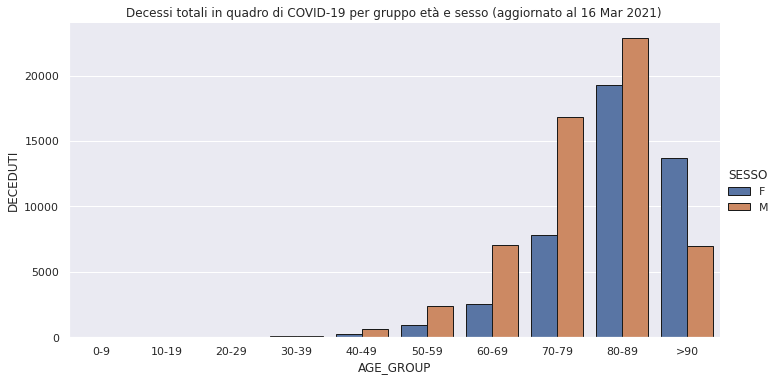

In [19]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta[(sesso_eta.AGE_GROUP!='Non noto')&(sesso_eta.SESSO!='Non noto')],
    x='AGE_GROUP', y='DECEDUTI',
    hue='SESSO',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per gruppo età e sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

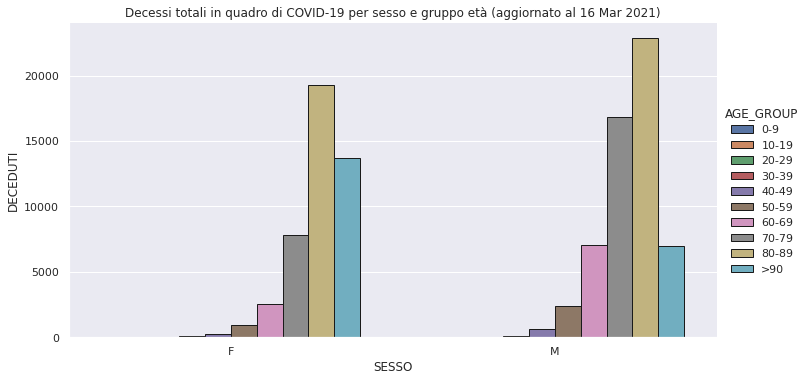

In [20]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta[(sesso_eta.AGE_GROUP!='Non noto')&(sesso_eta.SESSO!='Non noto')],
    hue='AGE_GROUP', y='DECEDUTI',
    x='SESSO',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per sesso e gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

In [21]:
sesso_eta_by_sex = sesso_eta.groupby('SESSO').sum().reset_index()

sesso_eta_by_sex['PERCENTUALE'] = sesso_eta_by_sex.DECEDUTI / sesso_eta_by_sex.CASI_CUMULATIVI

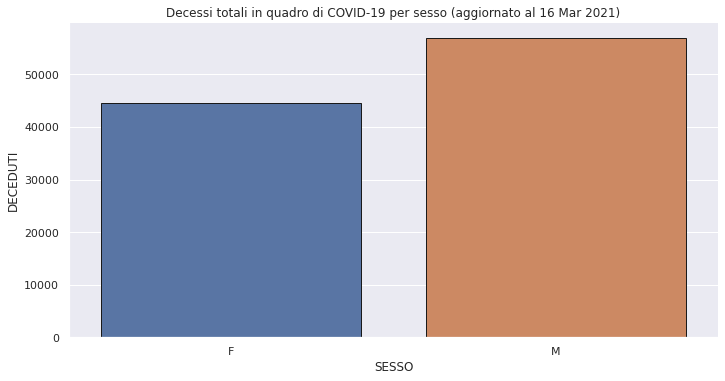

In [22]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_sex[sesso_eta_by_sex.SESSO!='Non noto'],
    x='SESSO', y='DECEDUTI',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

In [23]:
sesso_eta_by_age = sesso_eta.groupby('AGE_GROUP').sum().reset_index()

sesso_eta_by_age['PERCENTUALE'] = sesso_eta_by_age.DECEDUTI / sesso_eta_by_age.CASI_CUMULATIVI

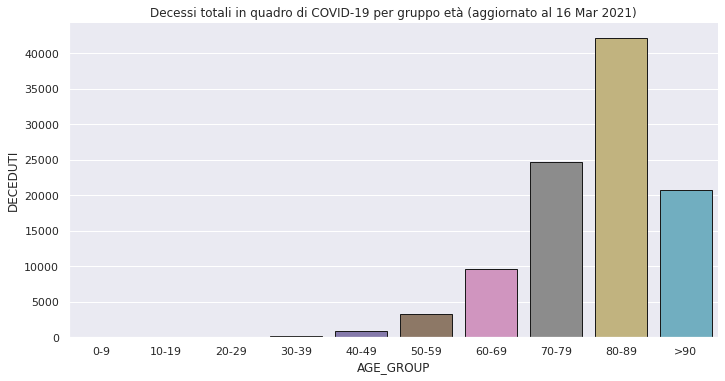

In [24]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='DECEDUTI',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

# LETALITÀ

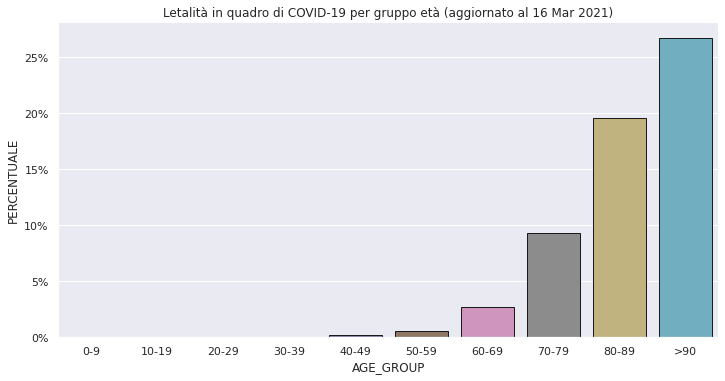

In [25]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='PERCENTUALE',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Letalità in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
g.axes.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

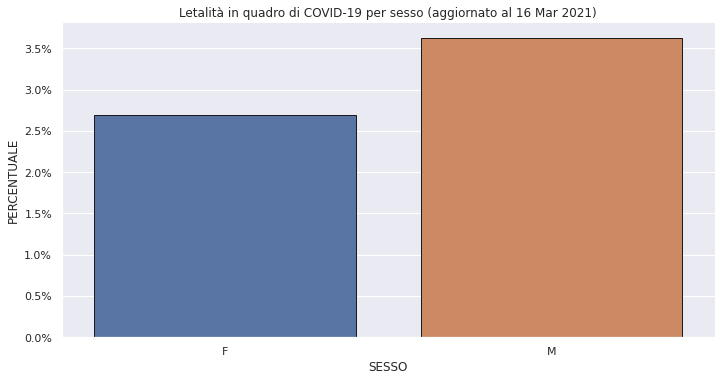

In [26]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_sex[sesso_eta_by_sex.SESSO!='Non noto'],
    x='SESSO', y='PERCENTUALE',
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Letalità in quadro di COVID-19 per sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().strftime('%d %b %Y')})"
)
g.axes.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

# MORTALITÀ

In [27]:
# Per ricostruire dataset decessi periodo Gen-Ott 2020
# da https://www.istat.it/it/archivio/240401
# https://www.istat.it/it/files//2020/03/Dataset-decessi-comunali-giornalieri_dati_mortalita_fino_31Ottobre2020.zip
_ = """decessi_istat = pd.read_csv(
    'comuni_giornaliero_31ottobre.csv',
    encoding="ISO-8859-1",
    na_values='n.d.'
)

fasce_eta_decessi = {
    '0-9': [0, 1, 2],
    '10-19': [3,4],
    '20-29': [5,6],
    '30-39': [7,8],
    '40-49': [9,10],
    '50-59': [11,12],
    '60-69': [13,14],
    '70-79': [15,16],
    '80-89': [17,18],
    '>90': [19,20,21],
}"""

In [28]:
# Per ricostruzione dataset decessi COVID-19 fino 9 dicembre 2020
_ = """decessi_storico = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/iss_epicentro_dati/processing/sesso_eta.csv',
)
decessi_storico['iss_date'] = pd.to_datetime(decessi_storico.iss_date, format='%d/%m/%Y')

decessi_storico_dicembre = decessi_storico.iloc[:28,:].copy(deep=True)

decessi_storico_dicembre.replace('<5', 4, inplace=True)

decessi_storico_dicembre = decessi_storico_dicembre[decessi_storico_dicembre.AGE_GROUP!='Non noto'].copy(deep=True)

decessi_storico_dicembre.DECEDUTI = decessi_storico_dicembre.DECEDUTI.astype(int)

decessi_storico_dicembre.CASI_CUMULATIVI = decessi_storico_dicembre.CASI_CUMULATIVI.astype(int)

decessi_storico_dicembre_sum = decessi_storico_dicembre.groupby('AGE_GROUP').sum()

decessi_storico_dicembre_sum.to_csv('decessi_covid_dicembre.csv')"""

In [29]:
# Per ricostruire dataset decessi covid-19 e totali periodo Gen-Nov 2020
_ = """eta_covid_decessi = pd.read_csv('decessi_covid_dicembre.csv')

for eta in eta_covid_decessi.AGE_GROUP.unique():
    d = decessi_istat[
        (decessi_istat.CL_ETA.isin(fasce_eta_decessi[eta]))
    ].T_20.sum()
    eta_covid_decessi.loc[eta_covid_decessi.AGE_GROUP==eta, 'DECESSI_TOT'] = d

eta_covid_decessi['PCT_COVID'] = eta_covid_decessi.DECEDUTI / eta_covid_decessi.DECESSI_TOT

eta_covid_decessi.to_csv('eta_covid_decessi.csv', index=False)"""

In [30]:
eta_covid_decessi = pd.read_csv('eta_covid_decessi.csv')

eta_covid_decessi['stima_decessi_31ottobre'] = \
eta_covid_decessi.DECEDUTI / eta_covid_decessi.DECEDUTI.sum() * cov[cov.index=='2020-10-31'].deceduti.values

eta_covid_decessi['stima_pct'] = \
eta_covid_decessi.stima_decessi_31ottobre / eta_covid_decessi.DECESSI_TOT

scarto = (cov[(cov.index=='2020-12-09')].deceduti.values - cov[(cov.index=='2020-11-01')].deceduti.values)[0]

In [31]:
display(Markdown(fr"""
**NOTA METODOLOGICA**:

Supposto che

1. i dati ISTAT dei decessi totali per fascia d'età sono attualmente disponibili fino al 31 Ottobre 2020
2. i dati ISS-EpiCentro dei decessi per fascia d'età in quadro di COVID-19 sono stati resi disponibili dal 9 Dicembre 2020

e dato che tra il 01 Novembre 2020 e il 09 Dicembre 2020 si sono registrati {scarto} decessi in più, in attesa dei dati aggiornati ISTAT:
"""))


**NOTA METODOLOGICA**:

Supposto che

1. i dati ISTAT dei decessi totali per fascia d'età sono attualmente disponibili fino al 31 Ottobre 2020
2. i dati ISS-EpiCentro dei decessi per fascia d'età in quadro di COVID-19 sono stati resi disponibili dal 9 Dicembre 2020

e dato che tra il 01 Novembre 2020 e il 09 Dicembre 2020 si sono registrati 22913 decessi in più, in attesa dei dati aggiornati ISTAT:


- si suppone che i decessi totali $D_\eta$ per fascia d'età $\eta$ del periodo Gennaio-Ottobre 2020 (dati ISTAT attualmente disponibili) siano una buona stima della mortalità generale del periodo scelto

$$
D_\eta \;,\; \eta \in [ \textrm{0-9}, \textrm{10-19} ... \textrm{100+} ]
$$

- si suppone che la distribuzione $d_\eta$ dei decessi in quadro di COVID-19 $X_\eta$ fino al 9 Dicembre 2020 per fascia d'età $\eta$ sia invariata rispetto rispetto alla distribuzione fino al 31 Ottobre 2020

$$
d_\eta = \frac{X_\eta}{\sum X}
$$

- si stimano quindi i decessi $C_\eta$ in quadro COVID-19 per fascia d'età $\eta$ in funzione del numero $C$ cumulativo di decessi totali per COVID-19 al 31 Ottobre 2020

$$
C_\eta = d_\eta C
$$

- si stima infine la percentuale $p_\eta$ di decessi in quadro di COVID-19 sul totale dei decessi per fascia d'età $\eta$

$$
p_\eta = \frac{C_\eta}{D_\eta}
$$

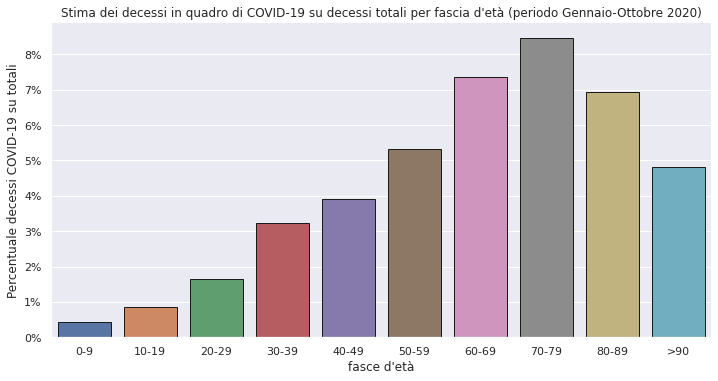

In [32]:
g = sns.catplot(
    kind='bar',
    data=eta_covid_decessi[eta_covid_decessi.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='stima_pct',
    ec='k',
    aspect=2,
)
g.axes.flat[0].set(
    title="Stima dei decessi in quadro di COVID-19 su decessi totali per fascia d'età "
    "(periodo Gennaio-Ottobre 2020)",
    xlabel="fasce d'età",
    ylabel="Percentuale decessi COVID-19 su totali"
)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

È interessante notare che

1. la maggior percentuale di decessi in quadro di COVID-19 sia relativa alla fascia d'età 70-79 e sia minore in fasce d'età superiori

2. per fasce d'età superiori ai 30 anni la percentuale di decessi in quadro di COVID-19 sia superiore al 3%

# STATO CLINICO

In [33]:
stato_clinico = pd.read_excel(
    url,
    sheet_name='stato_clinico',
    #parse_dates=['iss_date']
)

In [34]:
stato_clinico['iss_date'] = pd.to_datetime(stato_clinico.iss_date, format='%d/%m/%Y')

In [35]:
stato_clinico.replace('<5', 5, inplace=True)

In [36]:
stato_clinico['CASI'] = stato_clinico['CASI'].astype(int)

In [37]:
order = [
    'ASINTOMATICO',
    'PAUCI-SINTOMATICO',
    'LIEVE',
    'SEVERO',
    'CRITICO',
]

In [38]:
stato_clinico_by_sex = stato_clinico.groupby(['STATO_CLINICO', 'SESSO']).sum().reset_index()

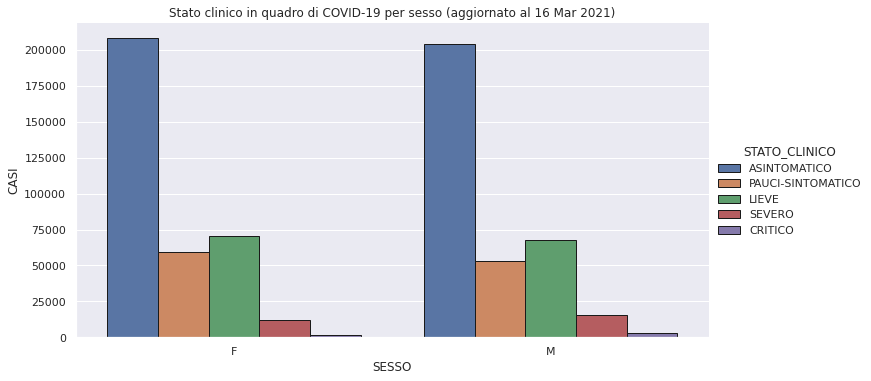

In [39]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='SESSO', y='CASI',
    hue='STATO_CLINICO',
    hue_order=order,
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

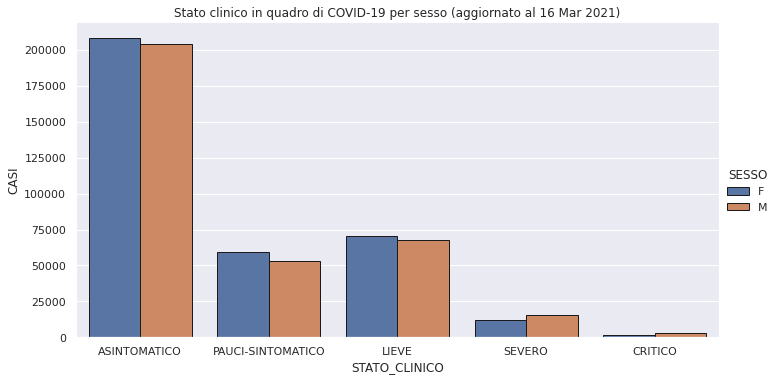

In [40]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='STATO_CLINICO', y='CASI',
    hue='SESSO',
    order=order,
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

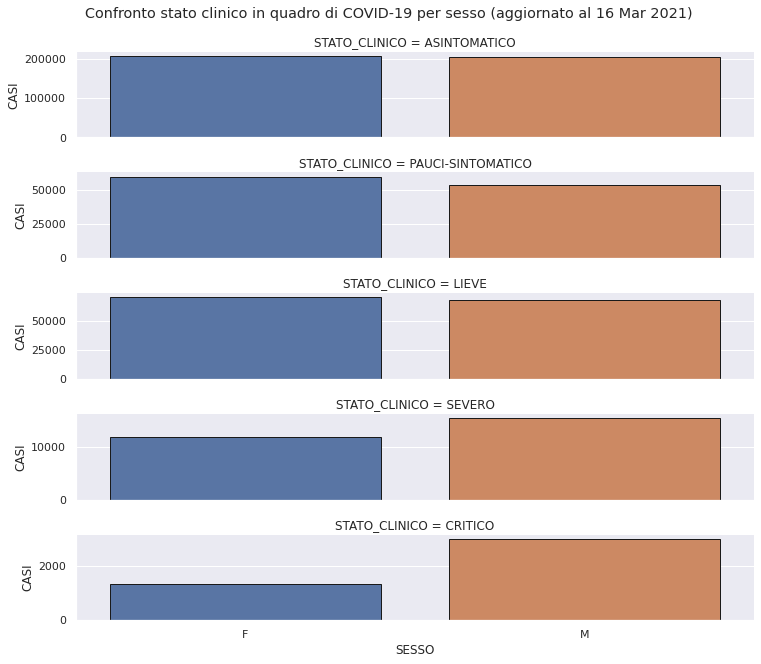

In [41]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='SESSO', y='CASI',
    row='STATO_CLINICO',
    #order=order,
    #col_wrap=2,
    row_order=order,
    ec='k',
    sharey=False,
    aspect=6, height=1.75,
)
g.fig.suptitle(
    "Confronto stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})",
    y=1.025
)
plt.show()

In [42]:
stato_clinico_by_age = stato_clinico.groupby(['STATO_CLINICO', 'AGE_GROUP']).sum().reset_index()

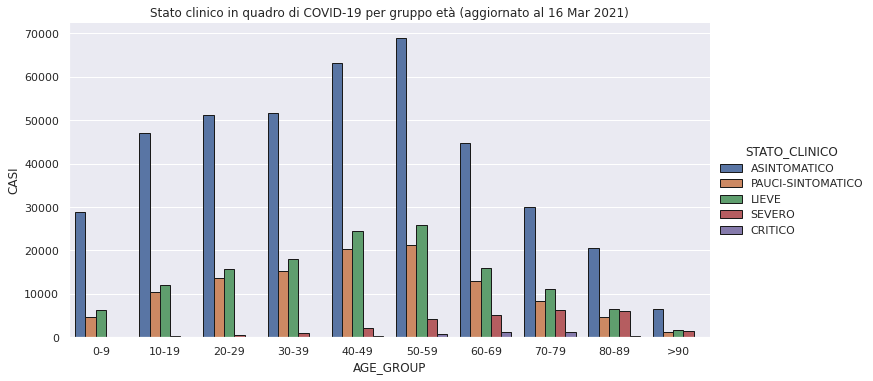

In [43]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='CASI',
    hue='STATO_CLINICO',
    hue_order=order,
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

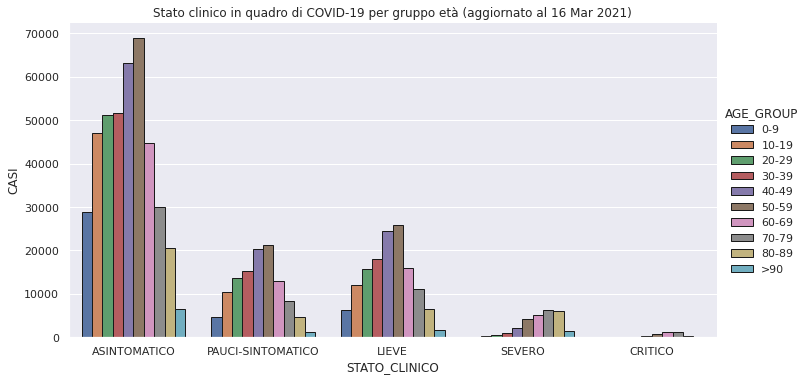

In [44]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='STATO_CLINICO', y='CASI',
    hue='AGE_GROUP',
    order=order,
    ec='k',
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})"
)
plt.show()

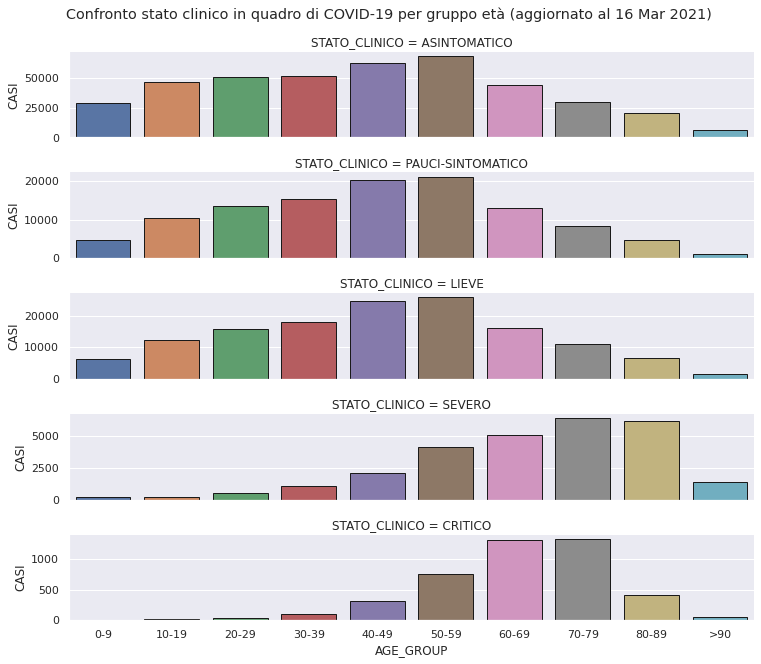

In [45]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='CASI',
    row='STATO_CLINICO',
    #order=order,
    #col_wrap=2,
    row_order=order,
    ec='k',
    sharey=False,
    aspect=6, height=1.75,
)
g.fig.suptitle(
    "Confronto stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().strftime('%d %b %Y')})",
    y=1.025
)
plt.show()